## 5.1 Installation and Setup (Colab)

In [ ]:
!git clone https://github.com/opendp/smartnoise-sdk

Check smartnoise-sdk is downloaded

In [ ]:
!ls

sample_data  smartnoise-sdk


Go into the folder that setup.py located

In [16]:
cd smartnoise-sdk/synth

/content/smartnoise-sdk/synth


In [ ]:
!ls

HISTORY.md  Makefile  pyproject.toml  README.md  setup.py  snsynth  tests


In [ ]:
!python setup.py build

In [ ]:
!python setup.py install

***Note: If you need to install the related packages below, after running "pip" you should restart runtime (in Colab environment). Only after restarting the runtime can the Colab succesfully has the packages loaded in the environemnt and then you are able to run the following cells.***

In [ ]:
!pip install diffprivlib 

In [ ]:
!pip install opacus

In [ ]:
!pip install threadpoolctl

In [ ]:
!pip install ctgan==0.4.3

Now we are able to import the synthesizer. Also, due to the previous `cd smartnoise-sdk/synth` command, our jupyter notebook is inside smartnoise-sdk/synth so importing `snsynth` shall not run into any problem!

In [1]:
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from diffprivlib.models import LogisticRegression as DPLR
from sklearn.metrics import classification_report
from snsynth.mwem import MWEMSynthesizer

import warnings
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN
from snsynth.pytorch.nn import PATECTGAN
warnings.filterwarnings("ignore")

In [2]:
def process_COMPAS(temp_df, is_GAN = False):
    """
    Pick columns = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 
    'juv_other_count', 'length_of_stay','race','two_year_recid', 'c_charge_degree'] 
    from the dataframe. Convert category data into numeric and remove races other 
    than Caucasian or African-American. 
    
    Input: COMPAS dataframe
    Output: 
           COMPAS dataframe after cleaning
            age_cat                    int64
            priors_count               int64
            sex_numeric                int64
            juv_fel_count              int64
            juv_misd_count             int64
            juv_other_count            int64
            c_charge_degree_numeric    int64
            length_of_stay             int64
            race                       int64
            two_year_recid             int64
    """
    # deepcopy
    df = temp_df.copy()
    
    # remove invalid/null entries
    df = df[(df['days_b_screening_arrest'] <= 30)
                & (df['days_b_screening_arrest'] >= -30)
                & (df['is_recid'] != -1)
                & (df['c_charge_degree'] != 'O')
                & (df['score_text'] != 'N/A')]
    # remove races other than Caucasian or African-American
    df = df[(df['race']=='Caucasian') | (df['race']=='African-American')]

    # calculate length_of_stay
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
    # the number of seconds to the unix epoch start
    df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).astype(int) / 10**9 
    # convert seconds into month
    df['length_of_stay'] /= 60 * 60 * 24 * 31
    df['length_of_stay'] = df['length_of_stay'].astype(int)
    df = df.drop_duplicates()

    # convert category data into numeric
    df['sex_numeric'] = pd.factorize(df['sex'])[0]
    df['c_charge_degree_numeric'] = pd.factorize(df['c_charge_degree'])[0]
    race = {0: 'Caucasian', 1: 'African-American'}
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    if is_GAN:
      # don't need to bin age
      df["age_cat"] = df["age"]
    else:
      age = {1: 'Greater than 45', 0: '25 - 45', -1: 'Less than 25'}
      df["age_cat"] = df["age_cat"].map({v: k for k, v in age.items()})

    cols = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree_numeric', 'length_of_stay','race','two_year_recid']
    df = df[cols]
    
    return df

In [3]:
def logisticRegression(x_train, y_train, x_test):
    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=500)
    logisticRegr.fit(x_train, y_train)

    train_predictions = logisticRegr.predict(x_train)
    test_predictions = logisticRegr.predict(x_test)
    return train_predictions, test_predictions

In [4]:
def predictionSummary(temp_x, y_real, y_predict, df):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict, labels=[0, 1]).ravel()
    # False Positive, False Negative, True Positive, True Negative, Overall Accuracy
    overall = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/y_real.shape[0]]

    x = temp_x.copy()
    x['medium_or_high_risk'] = y_predict
    x['two_year_recid'] = y_real
    
    # African-American
    x_black = x[df['race']==1].copy()
    tn, fp, fn, tp = confusion_matrix(x_black['two_year_recid'], x_black['medium_or_high_risk'], labels=[0, 1]).ravel()
    black = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    # Caucasian
    x_white = x[df['race']==0].copy()
    tn, fp, fn, tp = confusion_matrix(x_white['two_year_recid'], x_white['medium_or_high_risk'], labels=[0, 1]).ravel()
    white = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    return overall, black, white

In [5]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    def QuailSynth(epsilon):
      return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
    
    # Instantiate a DPLR classifier
    def QuailClassifier(epsilon):
      return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split) ## none for classifier

    return quail

In [12]:
def synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM"):
    test_results, train_results = [],[]
    # Loop through range of epsilon values
    for epsilon in epsilons:

        train_overall, train_black, train_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        test_overall, test_black, test_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        print(str(epsilon)+": ", end="")
        # Generate synthetic data many times (to average results)
        for i in range(niteration):
            print(str(i), end=", ")
            
            while True:
              # Generate synthetic training data
              if synthesizer == "MWEM":
                  synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15,
                                        splits=[], split_factor=6, max_bin_count=400) 
                  # learn the distribution of the real data
                  fit = synth.fit(train_data.to_numpy())  
              if synthesizer == "QUAIL":
                  synth = get_quail_synthesizer("DPLR", None, epsilon, None, target="two_year_recid")
                  fit = synth.fit(train_data)  
              if synthesizer == "DPCTGAN":
                  synth = PytorchDPSynthesizer(epsilon, DPCTGAN(), None)
                  fit = synth.fit(train_data, ['age_cat','race_numeric','c_charge_degree_numeric'])
              if synthesizer == "PATECTGAN":
                  synth = PytorchDPSynthesizer(epsilon, PATECTGAN(regularization='dragan'), None)
                  fit = synth.fit(train_data, ['age_cat','race_numeric','c_charge_degree_numeric'])

              sample_size = train_data.shape[0]
              train_synth = pd.DataFrame(synth.sample(sample_size), columns=train_data.columns) 
              # Split synthetic training data into X and y
              x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]

              if len(np.unique(y_train)) == 2:
                break
              else:
                print(np.unique(y_train, return_counts=True))

            # Run the binary classification pipeline
            y_train_predict, y_test_predict = logisticRegression(x_train, y_train, x_test)
            # Save results for each i and for each epsilon
            curr_train_overall, curr_train_black, curr_train_white = predictionSummary(x_train, y_train, y_train_predict, train_synth)
            curr_test_overall, curr_test_black, curr_test_white = predictionSummary(x_test, y_test, y_test_predict, test_data)
            
            train_overall = [rate1+rate2 for rate1,rate2 in zip(train_overall,curr_train_overall)]
            train_white = [rate1+rate2 for rate1,rate2 in zip(train_white,curr_train_white)]
            train_black = [rate1+rate2 for rate1,rate2 in zip(train_black,curr_train_black)]
            test_overall = [rate1+rate2 for rate1,rate2 in zip(test_overall,curr_test_overall)]
            test_white = [rate1+rate2 for rate1,rate2 in zip(test_white,curr_test_white)]
            test_black = [rate1+rate2 for rate1,rate2 in zip(test_black,curr_test_black)]

        print()
        train_overall = [rate/niteration for rate in train_overall]
        train_black = [rate/niteration for rate in train_black]
        train_white = [rate/niteration for rate in train_white]
        train_results.append([train_overall,train_black,train_white])
        test_overall = [rate/niteration for rate in test_overall]
        test_black = [rate/niteration for rate in test_black]
        test_white = [rate/niteration for rate in test_white]
        test_results.append([test_overall,test_black,test_white])
    return test_results, train_results
      

In [7]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

In [8]:
df = process_COMPAS(df)

In [9]:
df

,age_cat,priors_count,sex_numeric,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree_numeric,length_of_stay,race,two_year_recid
1,0,0,0,0,0,0,0,0,1,1
2,-1,4,0,0,0,1,0,0,1,1
6,0,14,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,0,0,0,0,1,0,1,1
7208,-1,0,0,0,0,0,0,0,1,0
7209,-1,0,0,0,0,0,0,0,1,0
7210,-1,0,0,0,0,0,0,0,1,0


## 5.2 MWEM

In [10]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [ ]:
epsilons = np.linspace(0.5,5,10) # get slow after >=7 

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_mwem = np.load("COMPAS_fairness_mwem.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_mwem["train_results"], COMPAS_fairness_mwem["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM")
    np.save("COMPAS_fairness_mwem.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

In [18]:
# test_results and train_results are list of list of list. The most outer list is based on different epsilon, 
# like [epsilon=0.5, epsilon=1, epsilon = 1.5, ...] 
# The middle list has three lists inside and they are in ther order of [overall, black, white] 
# The inner list has five values inside and they are [FPR, FNR, TPR, TNR, accuracy]

print(len(test_results))
print(len(test_results[0]))
print(len(test_results[0][0]))

10
3
5


In [54]:
def plotFPR(synthesizer, test_results, train_results, epsilons):
  f = plt.figure(figsize=(16,4))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.plot(epsilons,[result[0][0] for result in test_results],label="overall",color="blue",marker="o")
  ax.plot(epsilons,[result[1][0] for result in test_results],label="black",color="red",marker="o")
  ax.plot(epsilons,[result[2][0] for result in test_results],label="white",color="green",marker="o")
  ax.hlines(0.31346,xmin=min(epsilons), xmax=max(epsilons),label="non-private overall",linestyles="--",color="blue")
  ax.hlines(0.39185,xmin=min(epsilons), xmax=max(epsilons),label="non-private black",linestyles="--",color="red")
  ax.hlines(0.22015,xmin=min(epsilons), xmax=max(epsilons),label="non-private white",linestyles="--",color="green")
  ax.legend()
  ax.set_title(synthesizer + ": Testing: False Positive Rate versus epsilons")
  ax.set_ylabel("False Positive Rate")
  ax.set_xlabel("Epsilon")
  
  ax2.plot(epsilons,[result[0][0] for result in train_results],label="overall",color="blue",marker="o")
  ax2.plot(epsilons,[result[1][0] for result in train_results],label="black",color="red",marker="o")
  ax2.plot(epsilons,[result[2][0] for result in train_results],label="white",color="green",marker="o")
  ax2.hlines(0.25589,xmin=min(epsilons), xmax=max(epsilons),label="non-private overall",linestyles="--",color="blue")
  ax2.hlines(0.32385,xmin=min(epsilons), xmax=max(epsilons),label="non-private black",linestyles="--",color="red")
  ax2.hlines(0.17572,xmin=min(epsilons), xmax=max(epsilons),label="non-private white",linestyles="--",color="green")
  ax2.legend()
  ax2.set_title(synthesizer +": Training: False Positive Rate versus epsilons")
  ax2.set_ylabel("False Positive Rate")
  ax2.set_xlabel("Epsilon")

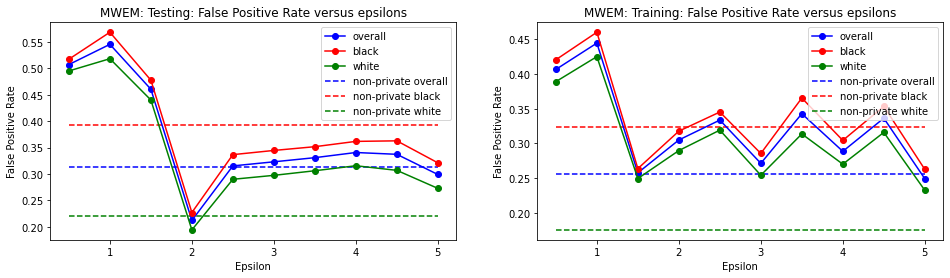

In [73]:
plotFPR("MWEM", test_results, train_results, epsilons)

In [52]:
def plotAccuracy(synthesizer, test_results, train_results, epsilons):
  plt.plot(epsilons,[result[0][4] for result in test_results],label="testing",color="r",marker="o")
  plt.plot(epsilons,[result[0][4] for result in train_results],label="training",color="b",marker="o")
  plt.hlines(0.62595,xmin=min(epsilons), xmax=max(epsilons),label="non-private testing",linestyles="--",color="r")
  plt.hlines(0.67669,xmin=min(epsilons), xmax=max(epsilons),label="non-private training",linestyles="--",color="b")
  plt.legend()
  plt.title(synthesizer +": Accuracy versus epsilons")
  plt.ylabel("Accuracy")
  plt.xlabel("Epsilon")


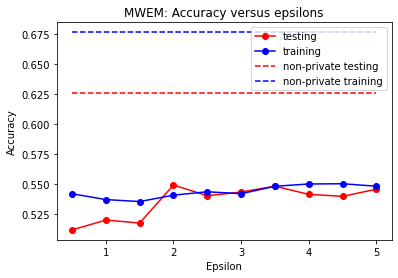

In [74]:
plotAccuracy("MWEM", test_results, train_results, epsilons)

In [70]:
def plotEqualizedOdds(synthesizer, test_results, train_results, epsilons, ylim=(-0.02,0.25)):
  f = plt.figure(figsize=(16,6))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  plt.suptitle(synthesizer + ": Equalized odds distances versus epsilons")

  # black TPR - white TPR
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_results],label="testing TPR diff",marker="o")
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in train_results],label="training TPR diff",marker="o")
  ax.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax.hlines(0.24133825777,xmin=min(epsilons), xmax=max(epsilons),label="non-private TPR diff",linestyles="--",color="red")
  ax.legend()
  ax.set_xlabel("Epsilon")
  ax.set_ylabel("Equalized odds distance")
  ax.set_ylim(ylim[0],ylim[1])
  ax.set_title(synthesizer + ": (TPR) Equalized odds distances versus epsilons")

  # black FPR - white FPR
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_results],label="testing FPR diff",marker="o")
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in train_results],label="training FPR diff",marker="o")
  ax2.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax2.hlines(0.13450471332,xmin=min(epsilons), xmax=max(epsilons),label="non-private FPR diff",linestyles="--",color="red")
  ax2.legend()
  ax2.set_xlabel("Epsilon")
  ax2.set_ylabel("Equalized odds distance")
  ax2.set_ylim(ylim[0],ylim[1])
  ax2.set_title(synthesizer + ": (FPT) Equalized odds distances versus epsilons")


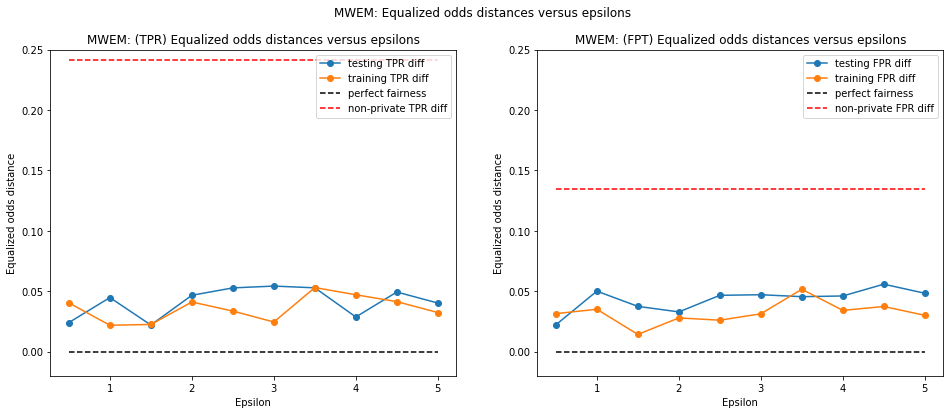

In [75]:
plotEqualizedOdds("MWEM", test_results, train_results, epsilons)


## 5.3 QUAIL

In [ ]:
epsilons = list(range(1,6))
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    np.save("COMPAS_fairness_QUAIL.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

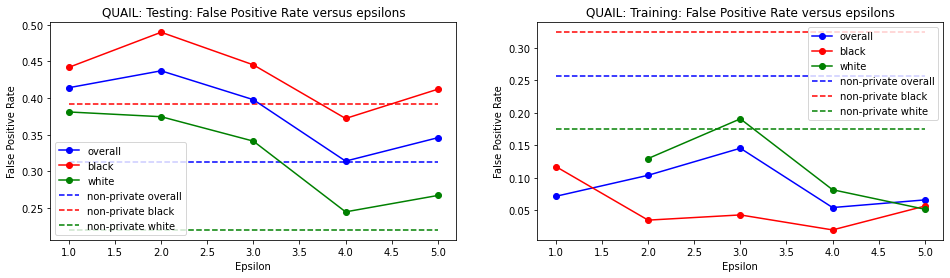

In [77]:
plotFPR("QUAIL", test_results, train_results, epsilons)

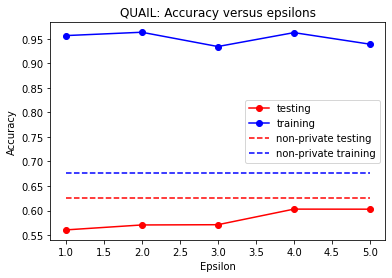

In [78]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

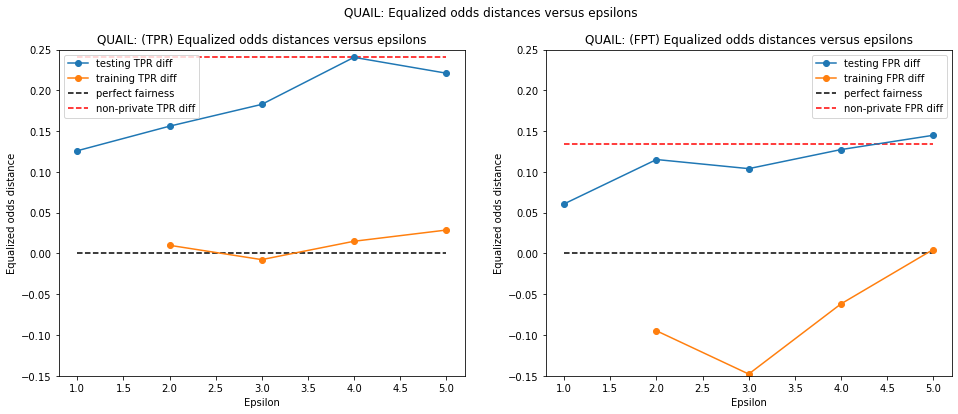

In [80]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons, [-0.15,0.25])


In [ ]:
# with 0.5 per iteration
epsilons = list(np.arange(1,6,0.5))

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL_2.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    np.save("COMPAS_fairness_QUAIL_2.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

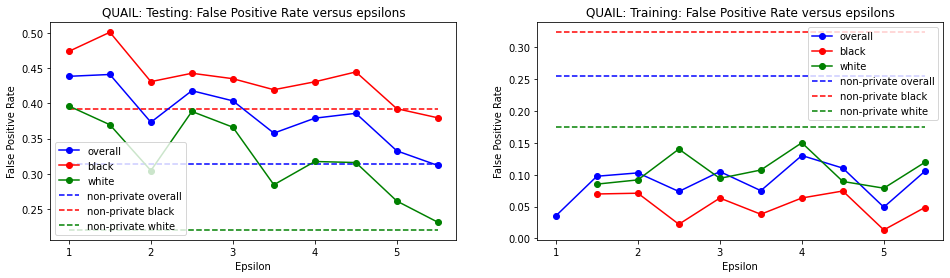

In [82]:
plotFPR("QUAIL", test_results, train_results, epsilons)

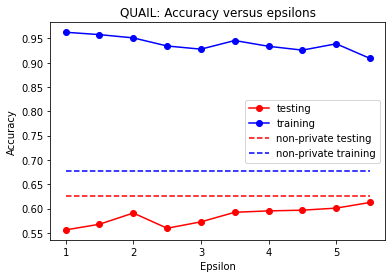

In [83]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

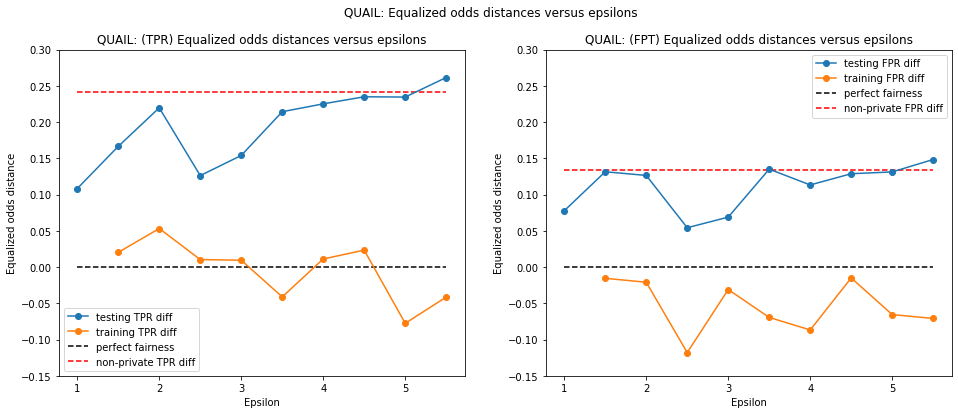

In [87]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons,[-0.15,0.30])


## 5.4 DPCTGAN

For DPCTGAN, the first GAN method we explored, we re-imported the data here because DPCTGAN is more capable of handling continous variables, so we don't bin ages into three intervals $(<25, 25-50, >50)$, unlike in MWEM and QUAIL. 

In [ ]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df = process_COMPAS(df, is_GAN = True)

In [ ]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=random.randint(0,100))

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [ ]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_DPCTGAN = np.load("COMPAS_fairness_DPCTGAN.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_DPCTGAN["train_results"], COMPAS_fairness_DPCTGAN["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="DPCTGAN")
    np.save("COMPAS_fairness_DPCTGAN.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

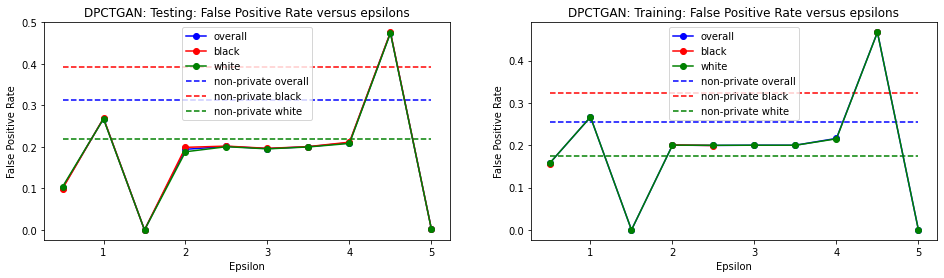

In [89]:
plotFPR("DPCTGAN", test_results, train_results, epsilons)

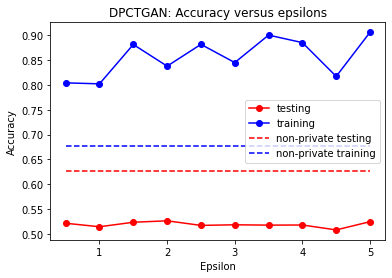

In [90]:
plotAccuracy("DPCTGAN", test_results, train_results, epsilons)

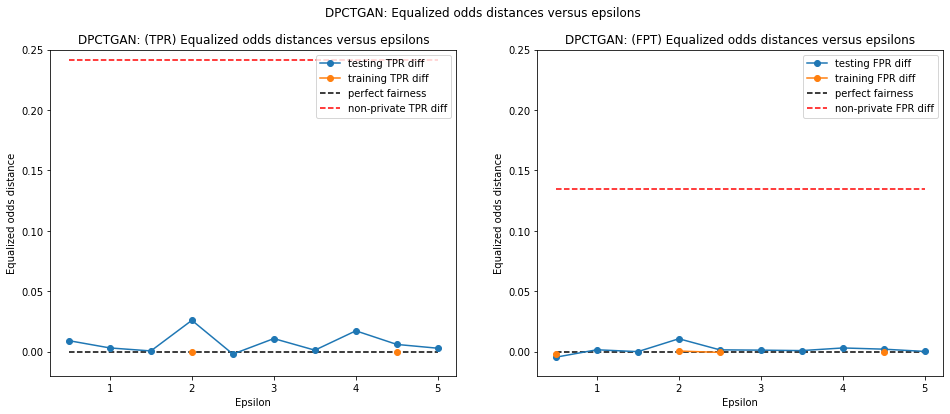

In [94]:
plotEqualizedOdds("DPCTGAN", test_results, train_results, epsilons,[-0.02,0.25])

In [ ]:
df = df[['age_cat','priors_count','sex_numeric','juv_fel_count', 'length_of_stay','race','two_year_recid']]

In [ ]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=random.randint(0,100))

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

## 5.5 PATECTGAN

In [ ]:
epsilons = np.linspace(0.5,5,10)
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_PATECTGAN = np.load("COMPAS_fairness_PATECTGAN.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_PATECTGAN["train_results"], COMPAS_fairness_PATECTGAN["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="PATECTGAN")
    np.save("COMPAS_fairness_PATECTGAN.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

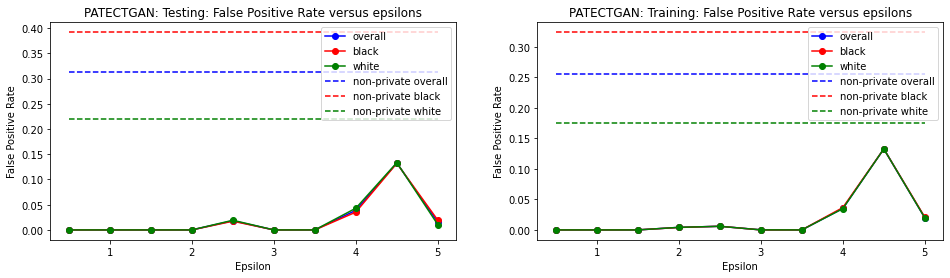

In [96]:
plotFPR("PATECTGAN", test_results, train_results, epsilons)

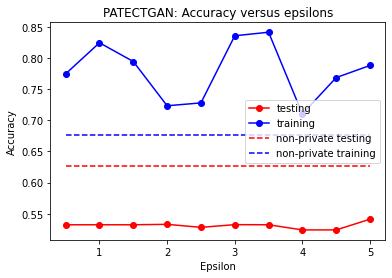

In [97]:
plotAccuracy("PATECTGAN", test_results, train_results, epsilons)

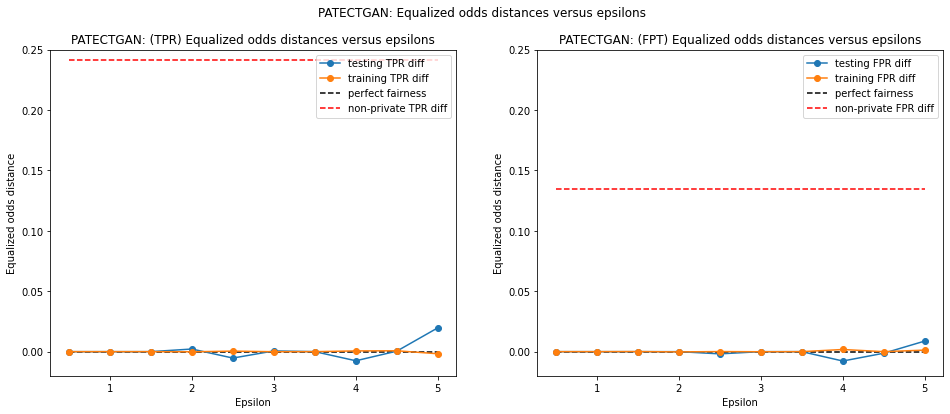

In [98]:
plotEqualizedOdds("PATECTGAN", test_results, train_results, epsilons)